In [1]:
import json
import re
import math
import pandas as pd
from collections import Counter

In [2]:
# ============================
# YC Companies Preprocessing
# ============================

import json
import re
import math
import pandas as pd
from IPython.display import display

# --------------------------------------
# Paths & Schema
# --------------------------------------
INPUT_PATH = "../data/yc-data-2025.jl"

REQUIRED_COLS = [
    "company_id", "company_name", "short_description", "long_description",
    "batch", "status", "tags", "location", "country", "year_founded",
    "num_founders", "founders_names", "founder_details", "team_size",
    "website", "cb_url", "linkedin_url"
]

# ------------ Helpers ------------
def load_jsonl(path):
    """Fast JSONL reader -> list[dict]."""
    records = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            records.append(json.loads(line))
    return records

def none_if_empty(x):
    """Normalize empty containers/strings to None."""
    if x in ("",):
        return None
    if isinstance(x, (list, dict)) and len(x) == 0:
        return None
    return x

def ensure_list(x):
    """Guarantee list type; turn None/str into sensible list."""
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return []
    if isinstance(x, list):
        return x
    # split comma/semicolon separated strings if given
    if isinstance(x, str):
        parts = [p.strip() for p in re.split(r"[;,]", x) if p.strip()]
        return parts
    return [x]

def to_int_or_none(x):
    try:
        return int(x)
    except Exception:
        return None

def parse_batch_to_year_season(batch):
    """
    Returns (batch_year, batch_season) from strings like:
      - 'W23', 'S24' (YC style)
      - 'Winter 2023', 'Summer 2024'
      - 'Fall 2025', 'Spring 2026'
    """
    if not isinstance(batch, str):
        return (None, None)
    b = batch.strip()

    # Compact form: W23 / S24
    m = re.fullmatch(r"([WS])(\d{2})", b, flags=re.I)
    if m:
        season = "Winter" if m.group(1).upper() == "W" else "Summer"
        year = 2000 + int(m.group(2))
        return (year, season)

    # Natural language season + year
    m = re.search(r"\b(Winter|Spring|Summer|Fall|Autumn)\b[\s\-]*(\d{4})", b, flags=re.I)
    if m:
        season = m.group(1).title()
        if season == "Autumn":  # normalize
            season = "Fall"
        year = int(m.group(2))
        return (year, season)

    # Bare year fallback
    m = re.search(r"(20\d{2})", b)
    if m:
        return (int(m.group(1)), None)

    return (None, None)

def normalize_tag_list(tag_list):
    """Normalize tags: trim/lowercase; drop empties."""
    if tag_list is None:
        return []
    normalized = []
    for tag in tag_list:
        if not isinstance(tag, str):
            continue
        t = tag.strip().lower()
        if t == "":
            continue
        normalized.append(t)
    return normalized

def normalize_founder_details(x):
    """Ensure founder_details is list[dict]."""
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return []
    if isinstance(x, list):
        return [d for d in x if isinstance(d, dict)]
    if isinstance(x, dict):
        return [x]
    if isinstance(x, str):
        try:
            v = json.loads(x)
            if isinstance(v, list):
                return [d for d in v if isinstance(d, dict)]
            if isinstance(v, dict):
                return [v]
        except Exception:
            pass
    return []

# ------------ Load ------------
records = load_jsonl(INPUT_PATH)
df = pd.DataFrame(records)

# ------------ Schema checks ------------
missing_cols = [c for c in REQUIRED_COLS if c not in df.columns]
unexpected_cols = [c for c in df.columns if c not in REQUIRED_COLS]

print("🔎 Schema check")
print(f"- Missing required columns: {missing_cols if missing_cols else 'None'}")
print(f"- Unexpected columns found: {unexpected_cols if unexpected_cols else 'None'}")

# Add any truly-missing required columns so downstream code won't break
for c in missing_cols:
    df[c] = None

# ------------ Basic normalization ------------
for c in df.columns:
    df[c] = df[c].map(none_if_empty)

# Types
df["company_id"]   = df["company_id"].map(to_int_or_none)
df["year_founded"] = df["year_founded"].map(to_int_or_none)
df["num_founders"] = df["num_founders"].map(to_int_or_none)
df["team_size"]    = df["team_size"].map(to_int_or_none)

# Lists
df["tags"] = df["tags"].map(ensure_list)
df["founders_names"] = df["founders_names"].map(ensure_list)

# Keep a copy of original tags for auditing/comparison
df["tags_original"] = df["tags"].copy()

# Apply normalization (lowercase and trim only)
df["tags"] = df["tags"].map(normalize_tag_list)

# founder_details should be a list[dict]; coerce if needed
df["founder_details"] = df["founder_details"].map(normalize_founder_details)

# Batch parsing -> add derived columns
df["batch"] = df["batch"].astype(str).str.strip()
df[["batch_year", "batch_season"]] = df["batch"].apply(lambda b: pd.Series(parse_batch_to_year_season(b)))

# ------------ Missingness report ------------
missing_ratio = df[REQUIRED_COLS].isna().mean().sort_values(ascending=False).to_frame("missing_ratio")
display(missing_ratio.head(20))

# ------------ Quick spot checks ------------
print("\n📊 Status counts:")
print(df["status"].value_counts(dropna=False).head(10))

print("\n🏷️ Top tags (exploded):")
tag_counts = df.explode("tags")["tags"].dropna()
print(tag_counts.value_counts().head(20))

print("\n🧾 Example rows:")
display(df.head(3))

# Optional: save a lightly cleaned copy for downstream analysis
df.to_parquet("yc_companies_clean.parquet", index=False)
print("\n✅ Saved cleaned file -> yc_companies_clean.parquet")

🔎 Schema check
- Missing required columns: None
- Unexpected columns found: None


,missing_ratio
cb_url,0.516390
linkedin_url,0.280800
year_founded,0.182457
location,0.102305
country,0.101765
long_description,0.064661
short_description,0.027738
team_size,0.017111
website,0.000180
status,0.000000



📊 Status counts:
status
Active      3852
Inactive     976
Acquired     704
Public        20
Name: count, dtype: int64

🏷️ Top tags (exploded):
tags
saas                       1138
b2b                        1084
artificial-intelligence     850
ai                          715
fintech                     698
developer-tools             533
marketplace                 306
generative-ai               267
e-commerce                  234
machine-learning            229
consumer                    224
healthcare                  197
analytics                   182
health-tech                 172
education                   166
productivity                163
open-source                 160
ai-assistant                152
payments                    147
climate                     144
Name: count, dtype: int64

🧾 Example rows:


,company_id,company_name,short_description,long_description,batch,status,tags,location,country,year_founded,num_founders,founders_names,founder_details,team_size,website,cb_url,linkedin_url,tags_original,batch_year,batch_season
0,31022,JSX Tool,AI-First In-Browser IDE for React Development,JSX Tool is a browser extension that hooks int...,Fall 2025,Active,"[artificial-intelligence, developer-tools, web...",None,None,2025.0,2,"[Jamie Sunderland, Dan Hyman]","[{'name': 'Jamie Sunderland', 'title': 'Founde...",2.0,https://jsxtool.com,None,None,"[artificial-intelligence, developer-tools, web...",2025,Fall
1,31021,Zephyr Fusion,Powering tomorrow's industrial revolution in s...,Zephyr Fusion is building the first in-orbit f...,Fall 2025,Active,"[fusion-energy, hard-tech, satellites, aerospace]","San Diego, CA",US,2025.0,2,"[Galen Burke, Edward Hinson]","[{'name': 'Galen Burke', 'title': 'Founder', '...",2.0,https://www.zephyrfusion.com,None,None,"[fusion-energy, hard-tech, satellites, aerospace]",2025,Fall
2,31018,item,The AI-Native CRM that works for you,"item connects to all your customer tools, gath...",Fall 2025,Active,"[b2b, automation, ai-assistant]",San Francisco,US,2024.0,2,"[Akshay Guthal, Andres Santanilla]","[{'name': 'Akshay Guthal', 'title': 'Founder',...",3.0,https://item.app,None,https://www.linkedin.com/company/99138518,"[b2b, automation, ai-assistant]",2025,Fall



✅ Saved cleaned file -> yc_companies_clean.parquet


In [3]:
import pandas as pd
import plotly.express as px

# ------------------------------------
# ✅ 1. Use raw 'location' exactly as-is
# ------------------------------------
df["location_clean"] = df["location"]

# Filter missing/empty
location_counts = (
    df[df["location_clean"].notnull() & (df["location_clean"].astype(str).str.strip() != "")]
    .groupby("location_clean")
    .size()
    .reset_index(name="count")
)

display(location_counts.sort_values("count", ascending=False).head(20))

,location_clean,count
301,San Francisco,2044
237,New York,528
189,"London, United Kingdom",133
27,"Bengaluru, India",108
192,"Los Angeles, CA",107
262,Palo Alto,95
227,Mountain View,85
349,"Toronto, Canada",73
36,Boston,61
264,"Paris, France",55


In [8]:
import pandas as pd
import plotly.express as px

print("🔍 INVESTIGATING THE DATA:")
print(f"   Total companies in dataset: {len(df)}")
print(f"   Companies with batch_year: {df['batch_year'].notnull().sum()}")
print(f"   Batch year range: {df['batch_year'].min():.0f} to {df['batch_year'].max():.0f}")
print(f"\n   All unique batch years in dataset:")
all_years = sorted([int(y) for y in df['batch_year'].dropna().unique()])
print(f"   {all_years}\n")

# ------------------------------------
# Load health-related tags from file
# ------------------------------------
HEALTH_TAGS_FILE = "yc_health_tags.txt"

with open(HEALTH_TAGS_FILE, "r", encoding="utf-8") as f:
    health_tags = [line.strip().lower() for line in f if line.strip()]

print(f"📋 Loaded {len(health_tags)} health-related tags")
print(f"   Sample: {', '.join(health_tags[:5])}...\n")

# ------------------------------------
# Check health companies across ALL years
# ------------------------------------
df_health = df.copy()
df_health = df_health[df_health["batch_year"].notnull()]
df_health["batch_year"] = df_health["batch_year"].astype(int)

# Check if company has ANY health tag
def has_health_tag(tag_list):
    """Check if any tag in the list is a health tag."""
    if not isinstance(tag_list, list):
        return False
    return any(tag in health_tags for tag in tag_list)

df_health["has_health_tag"] = df_health["tags"].apply(has_health_tag)

# Show companies per year BEFORE filtering by health tags
print("📊 ALL companies per batch year (before health filter):")
all_companies_per_year = df_health.groupby("batch_year")["company_id"].nunique().reset_index(name="total_companies")
display(all_companies_per_year)

# Filter to only companies with health tags
df_health = df_health[df_health["has_health_tag"]]

print(f"\n🏥 Health companies found: {len(df_health)}")
print(f"   Year range with health tags: {df_health['batch_year'].min()} to {df_health['batch_year'].max()}")

# Count companies per year for health companies
health_companies_per_year = df_health.groupby("batch_year")["company_id"].nunique().reset_index(name="health_companies")

# Merge with all companies to see the difference
companies_comparison = all_companies_per_year.merge(health_companies_per_year, on="batch_year", how="left")
companies_comparison["health_companies"] = companies_comparison["health_companies"].fillna(0).astype(int)
companies_comparison["percentage"] = (companies_comparison["health_companies"] / companies_comparison["total_companies"] * 100).round(1)

print(f"\n{'='*80}")
print("📊 HEALTH COMPANIES PER YEAR - COMPLETE TABLE")
print(f"{'='*80}")
display(companies_comparison)
print(f"{'='*80}")
print(f"✅ Total unique health companies: {df_health['company_id'].nunique()}")
print(f"{'='*80}\n")

# ------------------------------------
# Create line chart (only years with health companies)
# ------------------------------------
companies_per_year = health_companies_per_year.copy()
companies_per_year.columns = ["batch_year", "company_count"]

fig = px.line(
    companies_per_year,
    x="batch_year",
    y="company_count",
    markers=True,
    title="YC Investment in Health & Biotech Over Time<br><sub>Number of unique companies with health-related tags per batch year</sub>",
    labels={
        "batch_year": "Batch Year",
        "company_count": "Number of Companies"
    }
)

fig.update_layout(
    width=1100,
    height=650,
    hovermode="x unified",
    title_font_size=20,
    plot_bgcolor="#ffffff",
    xaxis=dict(
        showgrid=True, 
        gridcolor="rgba(200,200,200,0.25)",
        dtick=1
    ),
    yaxis=dict(showgrid=True, gridcolor="rgba(200,200,200,0.25)")
)

fig.update_traces(
    line=dict(width=3, color="#3498db"),
    marker=dict(size=8)
)

fig.show()

# ------------------------------------
# Show top health tags
# ------------------------------------
print("\n🏷️ Top 20 health tags in dataset:")
health_tag_counts = df_health.explode("tags")["tags"]
health_tag_counts = health_tag_counts[health_tag_counts.isin(health_tags)]
display(health_tag_counts.value_counts().head(20))

🔍 INVESTIGATING THE DATA:
   Total companies in dataset: 5552
   Companies with batch_year: 5552
   Batch year range: 2005 to 2025

   All unique batch years in dataset:
   [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

📋 Loaded 45 health-related tags
   Sample: ai-powered-drug-discovery, anti-aging, biometrics, biotech, biotechnology...

📊 ALL companies per batch year (before health filter):


,batch_year,total_companies
0,2005,9
1,2006,18
2,2007,32
3,2008,43
4,2009,42
5,2010,63
6,2011,105
7,2012,149
8,2013,98
9,2014,152



🏥 Health companies found: 687
   Year range with health tags: 2010 to 2025

📊 HEALTH COMPANIES PER YEAR - COMPLETE TABLE


,batch_year,total_companies,health_companies,percentage
0,2005,9,0,0.0
1,2006,18,0,0.0
2,2007,32,0,0.0
3,2008,43,0,0.0
4,2009,42,0,0.0
5,2010,63,2,3.2
6,2011,105,4,3.8
7,2012,149,9,6.0
8,2013,98,11,11.2
9,2014,152,18,11.8


✅ Total unique health companies: 687




🏷️ Top 20 health tags in dataset:


tags
healthcare                   197
health-tech                  172
biotech                      131
digital-health               107
consumer-health-services     104
medical-devices               66
therapeutics                  45
health-&-wellness             41
ai-powered-drug-discovery     39
healthcare-it                 38
mental-health-tech            37
diagnostics                   32
synthetic-biology             31
drug-discovery                31
telemedicine                  29
health-insurance              28
genomics                      27
telehealth                    27
oncology                      20
fitness                       18
Name: count, dtype: int64

In [18]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# ------------------------------------
# Health Companies Location Analysis
# ------------------------------------
print("🌍 ANALYZING LOCATIONS OF HEALTH & BIOTECH COMPANIES\n")

# Load health tags
HEALTH_TAGS_FILE = "yc_health_tags.txt"
with open(HEALTH_TAGS_FILE, "r", encoding="utf-8") as f:
    health_tags = [line.strip().lower() for line in f if line.strip()]

# Filter for health companies
def has_health_tag(tag_list):
    if not isinstance(tag_list, list):
        return False
    return any(tag in health_tags for tag in tag_list)

df_health_loc = df[df["tags"].apply(has_health_tag)].copy()

print(f"📊 Total health companies: {len(df_health_loc)}")
print(f"   Companies with location data: {df_health_loc['location'].notnull().sum()}")
print(f"   Companies without location: {df_health_loc['location'].isnull().sum()}\n")

# Count companies by location
location_counts = (
    df_health_loc[df_health_loc["location"].notnull()]
    .groupby("location")["company_id"]
    .nunique()
    .reset_index(name="company_count")
    .sort_values("company_count", ascending=False)
)

# Calculate percentage
location_counts["percentage"] = (location_counts["company_count"] / location_counts["company_count"].sum() * 100).round(1)

print("="*80)
print("📍 TOP LOCATIONS FOR HEALTH & BIOTECH COMPANIES")
print("="*80)
display(location_counts.head(30))
print("="*80)
print(f"✅ Total unique locations: {len(location_counts)}")
print("="*80 + "\n")

# ------------------------------------
# Create visual table for top 20 locations
# ------------------------------------
top_20_locations = location_counts.head(20)

fig_loc_table = go.Figure(data=[go.Table(
    header=dict(
        values=['<b>Location</b>', '<b>Health Companies</b>', '<b>Percentage</b>'],
        fill_color='#e74c3c',  # Red/orange color for health theme
        font=dict(color='white', size=14),
        align=['left', 'center', 'center'],
        height=30
    ),
    cells=dict(
        values=[
            top_20_locations['location'],
            top_20_locations['company_count'],
            top_20_locations['percentage'].apply(lambda x: f"{x}%")
        ],
        fill_color=[['#f8f9fa' if i % 2 == 0 else 'white' for i in range(len(top_20_locations))]],
        font=dict(size=12),
        align=['left', 'center', 'center'],
        height=35
    )
)])

fig_loc_table.update_layout(
    title=dict(
        text="Top 20 Locations for YC Health & Biotech Companies",
        font=dict(size=18, color='#2c3e50'),
        x=0.5,
        xanchor='center'
    ),
    width=900,
    height=850,
    margin=dict(l=20, r=20, t=80, b=20)
)

fig_loc_table.show()

🌍 ANALYZING LOCATIONS OF HEALTH & BIOTECH COMPANIES

📊 Total health companies: 687
   Companies with location data: 661
   Companies without location: 26

📍 TOP LOCATIONS FOR HEALTH & BIOTECH COMPANIES


,location,company_count,percentage
93,San Francisco,234,35.4
71,New York,72,10.9
12,Boston,22,3.3
53,"London, United Kingdom",20,3.0
54,"Los Angeles, CA",14,2.1
79,Palo Alto,11,1.7
16,"Cambridge, MA",11,1.7
66,Mountain View,10,1.5
8,"Bengaluru, India",10,1.5
98,"Seattle, WA",9,1.4


✅ Total unique locations: 118



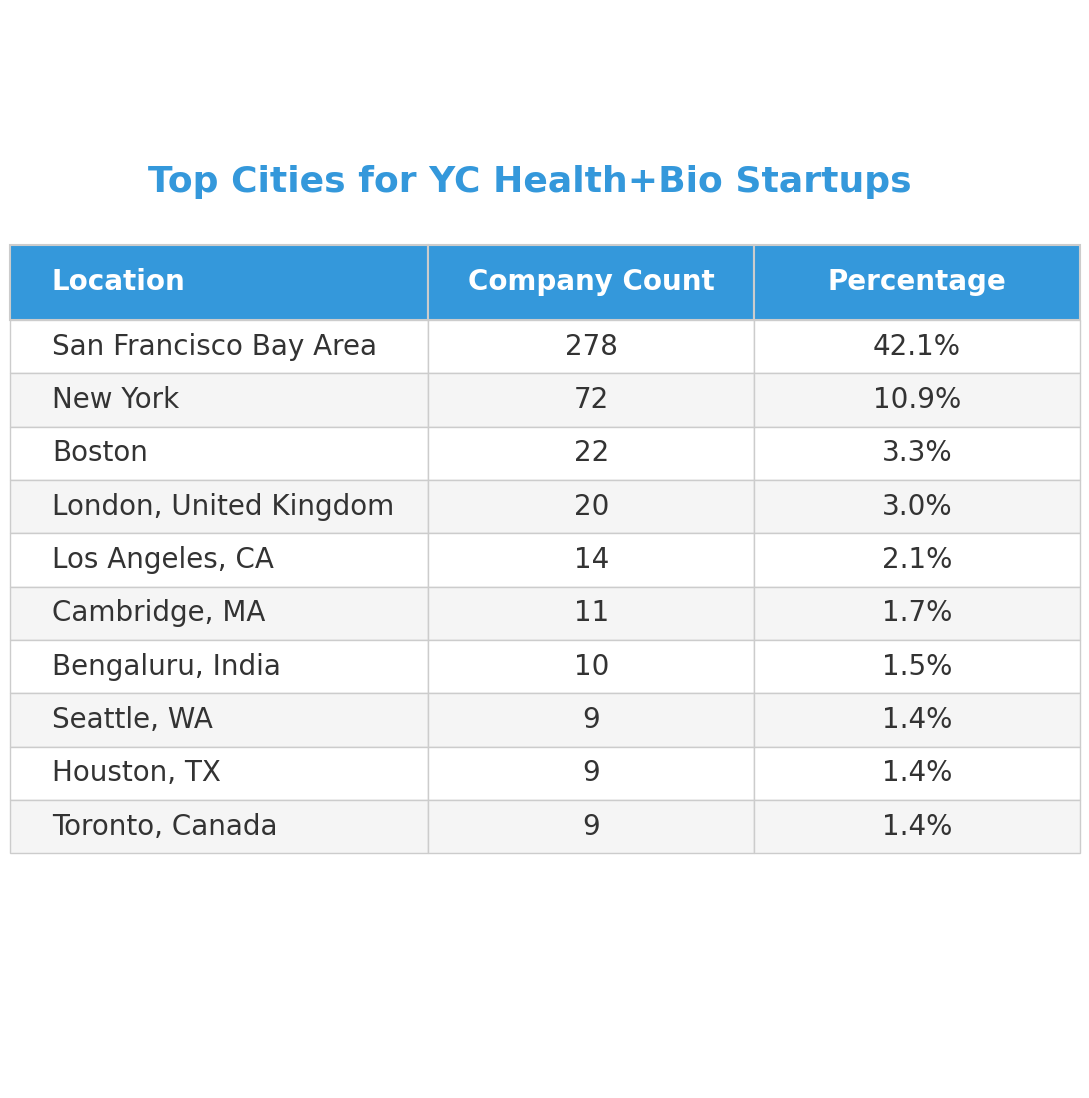

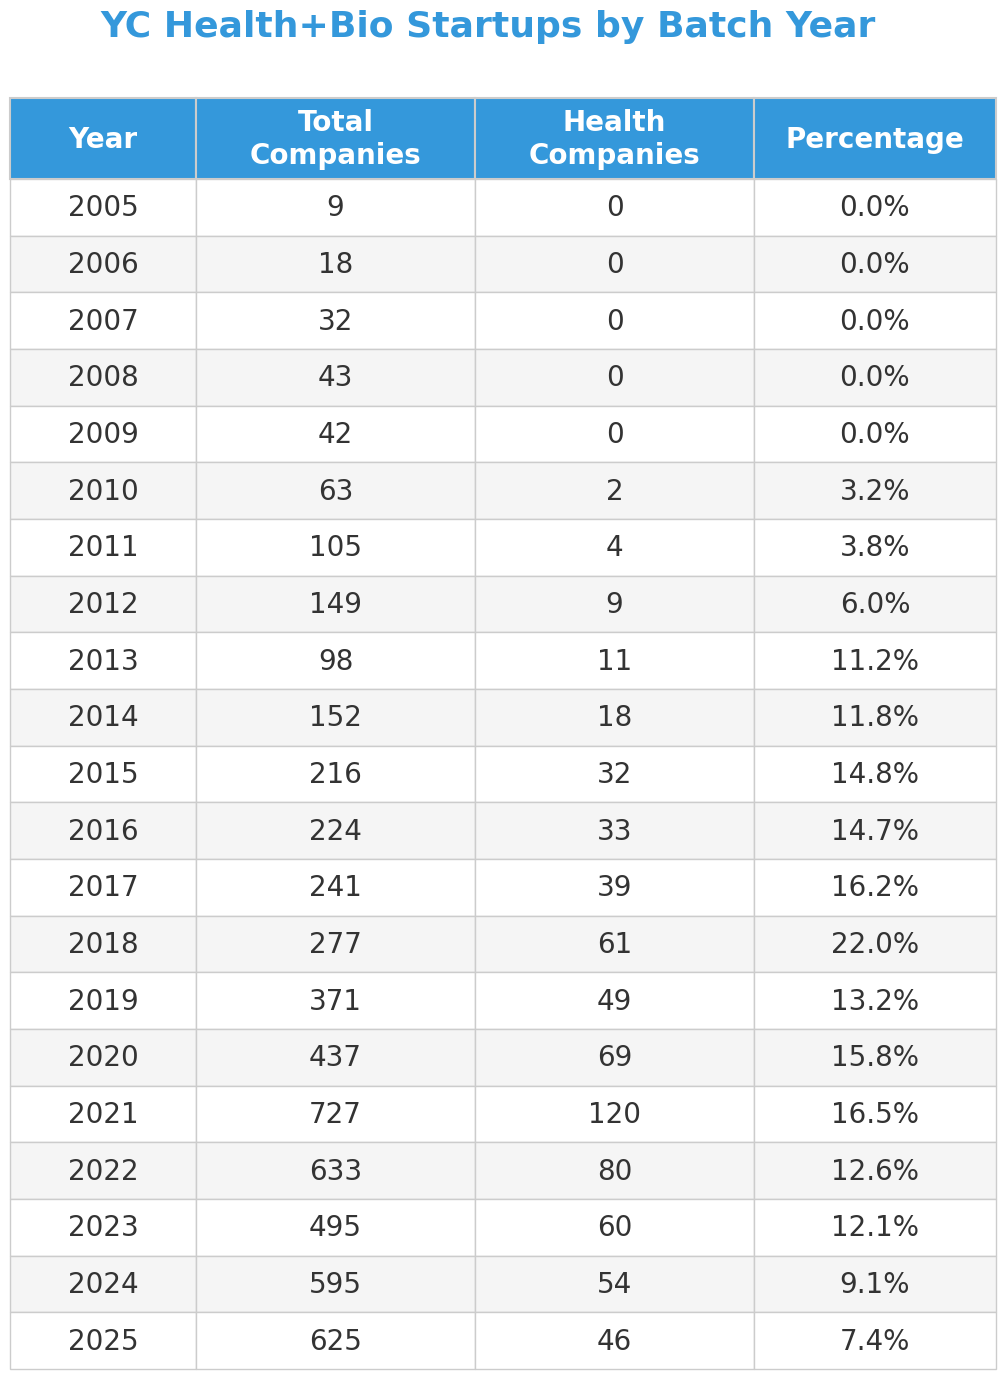

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Set up the style
plt.style.use('default')

# Table 1: Location Data
fig1, ax1 = plt.subplots(figsize=(12, 14))
ax1.axis('tight')
ax1.axis('off')

# Data for table 1 - merged San Francisco Bay Area cities
locations = [
    ['San Francisco Bay Area', '278', '42.1%'],
    ['New York', '72', '10.9%'],
    ['Boston', '22', '3.3%'],
    ['London, United Kingdom', '20', '3.0%'],
    ['Los Angeles, CA', '14', '2.1%'],
    ['Cambridge, MA', '11', '1.7%'],
    ['Bengaluru, India', '10', '1.5%'],
    ['Seattle, WA', '9', '1.4%'],
    ['Houston, TX', '9', '1.4%'],
    ['Toronto, Canada', '9', '1.4%'],
]

# Create table with wider Percentage column
table1 = ax1.table(cellText=locations,
                   colLabels=['Location', 'Company Count', 'Percentage'],
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.45, 0.35, 0.35])

# Style the table
table1.auto_set_font_size(False)
table1.set_fontsize(20)
table1.scale(1, 3.2)

# Style header with blue color
for i in range(3):
    cell = table1[(0, i)]
    cell.set_facecolor('#3498db')  # Bright blue
    cell.set_text_props(weight='bold', color='white', size=20)
    cell.set_height(0.07)  # Increased height for better fit
    cell.set_edgecolor('#cccccc')
    cell.set_linewidth(1.5)
    if i == 0:
        cell.set_text_props(weight='bold', color='white', size=20, ha='left')
    else:
        cell.set_text_props(weight='bold', color='white', size=20, ha='center')

# Style data rows - simple alternating
for i in range(len(locations)):
    for j in range(3):
        cell = table1[(i+1, j)]
        if i % 2 == 0:
            cell.set_facecolor('white')
        else:
            cell.set_facecolor('#f5f5f5')
        cell.set_edgecolor('#cccccc')
        cell.set_linewidth(1)
        
        # Left align location, center align numbers - NO BOLD for numbers
        if j == 0:
            cell.set_text_props(color='#333333', size=20, ha='left')
        else:
            cell.set_text_props(color='#333333', size=20, ha='center')

# Add title closer to table
title1 = fig1.text(0.5, 0.75, 'Top Cities for YC Health+Bio Startups', 
                   ha='center', fontsize=26, weight='bold', color='#3498db')

# White background
fig1.patch.set_facecolor('white')

plt.savefig('../figures/table1_locations.png', 
            dpi=300, bbox_inches='tight', facecolor='white', pad_inches=0.3)

plt.show()
plt.close()

# Table 2: YC Batch Year Data
fig2, ax2 = plt.subplots(figsize=(12, 15))
ax2.axis('tight')
ax2.axis('off')

# Data for table 2
batch_data = [
    ['2005', '9', '0', '0.0%'],
    ['2006', '18', '0', '0.0%'],
    ['2007', '32', '0', '0.0%'],
    ['2008', '43', '0', '0.0%'],
    ['2009', '42', '0', '0.0%'],
    ['2010', '63', '2', '3.2%'],
    ['2011', '105', '4', '3.8%'],
    ['2012', '149', '9', '6.0%'],
    ['2013', '98', '11', '11.2%'],
    ['2014', '152', '18', '11.8%'],
    ['2015', '216', '32', '14.8%'],
    ['2016', '224', '33', '14.7%'],
    ['2017', '241', '39', '16.2%'],
    ['2018', '277', '61', '22.0%'],
    ['2019', '371', '49', '13.2%'],
    ['2020', '437', '69', '15.8%'],
    ['2021', '727', '120', '16.5%'],
    ['2022', '633', '80', '12.6%'],
    ['2023', '495', '60', '12.1%'],
    ['2024', '595', '54', '9.1%'],
    ['2025', '625', '46', '7.4%'],
]

# Create table
table2 = ax2.table(cellText=batch_data,
                   colLabels=['Year', 'Total\nCompanies', 'Health\nCompanies', 'Percentage'],
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.2, 0.3, 0.3, 0.26])

# Style the table
table2.auto_set_font_size(False)
table2.set_fontsize(20)
table2.scale(1, 3.4)

# Style header with blue color
for i in range(4):
    cell = table2[(0, i)]
    cell.set_facecolor('#3498db')  # Bright blue
    cell.set_text_props(weight='bold', color='white', size=20)
    cell.set_height(0.07)  # Increased height for better fit
    cell.set_edgecolor('#cccccc')
    cell.set_linewidth(1.5)

# Style data rows - simple alternating
for i in range(len(batch_data)):
    for j in range(4):
        cell = table2[(i+1, j)]
        if i % 2 == 0:
            cell.set_facecolor('white')
        else:
            cell.set_facecolor('#f5f5f5')
        cell.set_edgecolor('#cccccc')
        cell.set_linewidth(1)
        cell.set_text_props(color='#333333', size=20)

# Add title with proper spacing from table
title2 = fig2.text(0.5, 0.96, 'YC Health+Bio Startups by Batch Year', 
                   ha='center', fontsize=26, weight='bold', color='#3498db')

# White background
fig2.patch.set_facecolor('white')

plt.savefig('../figures/table2_batch_years.png', 
            dpi=300, bbox_inches='tight', facecolor='white', pad_inches=0.3)

plt.show()

plt.close()

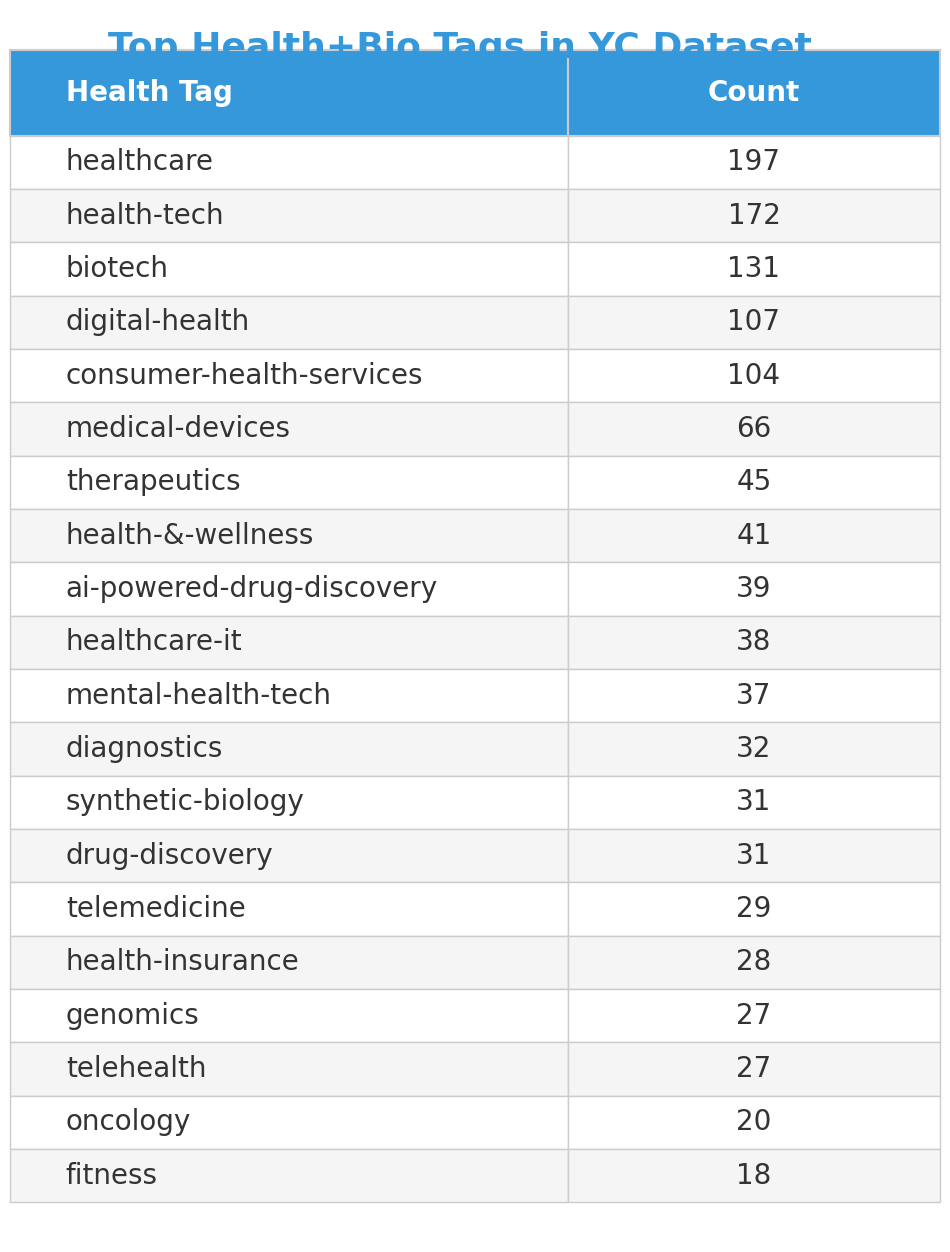

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Set up the style
plt.style.use('default')

# Table 3: Health Tags Data
fig3, ax3 = plt.subplots(figsize=(12, 16))
ax3.axis('tight')
ax3.axis('off')

# Data for table 3 - Top 20 health tags
health_tags_data = [
    ['healthcare', '197'],
    ['health-tech', '172'],
    ['biotech', '131'],
    ['digital-health', '107'],
    ['consumer-health-services', '104'],
    ['medical-devices', '66'],
    ['therapeutics', '45'],
    ['health-&-wellness', '41'],
    ['ai-powered-drug-discovery', '39'],
    ['healthcare-it', '38'],
    ['mental-health-tech', '37'],
    ['diagnostics', '32'],
    ['synthetic-biology', '31'],
    ['drug-discovery', '31'],
    ['telemedicine', '29'],
    ['health-insurance', '28'],
    ['genomics', '27'],
    ['telehealth', '27'],
    ['oncology', '20'],
    ['fitness', '18'],
]

# Create table
table3 = ax3.table(cellText=health_tags_data,
                   colLabels=['Health Tag', 'Count'],
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.6, 0.4])

# Style the table
table3.auto_set_font_size(False)
table3.set_fontsize(20)
table3.scale(1, 3.2)

# Style header with blue color
for i in range(2):
    cell = table3[(0, i)]
    cell.set_facecolor('#3498db')  # Bright blue
    cell.set_text_props(weight='bold', color='white', size=20)
    cell.set_height(0.07)  # Increased height for better fit
    cell.set_edgecolor('#cccccc')
    cell.set_linewidth(1.5)
    if i == 0:
        cell.set_text_props(weight='bold', color='white', size=20, ha='left')
    else:
        cell.set_text_props(weight='bold', color='white', size=20, ha='center')

# Style data rows - simple alternating
for i in range(len(health_tags_data)):
    for j in range(2):
        cell = table3[(i+1, j)]
        if i % 2 == 0:
            cell.set_facecolor('white')
        else:
            cell.set_facecolor('#f5f5f5')
        cell.set_edgecolor('#cccccc')
        cell.set_linewidth(1)
        
        # Left align tag, center align count
        if j == 0:
            cell.set_text_props(color='#333333', size=20, ha='left')
        else:
            cell.set_text_props(color='#333333', size=20, ha='center')

# Add title closer to table
title3 = fig3.text(0.5, 0.9, 'Top Health+Bio Tags in YC Dataset', 
                   ha='center', fontsize=26, weight='bold', color='#3498db')

# White background
fig3.patch.set_facecolor('white')

plt.savefig('../figures/table3_health_tags.png', 
            dpi=300, bbox_inches='tight', facecolor='white', pad_inches=0.3)

plt.show()
plt.close()